In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Dropout
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [25]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [26]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
cifar10_labels = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess data
SIZE = 32  
x_train = x_train / 255.0  
x_test = x_test / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

In [28]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [29]:
x_train_flat.shape

(50000, 3072)

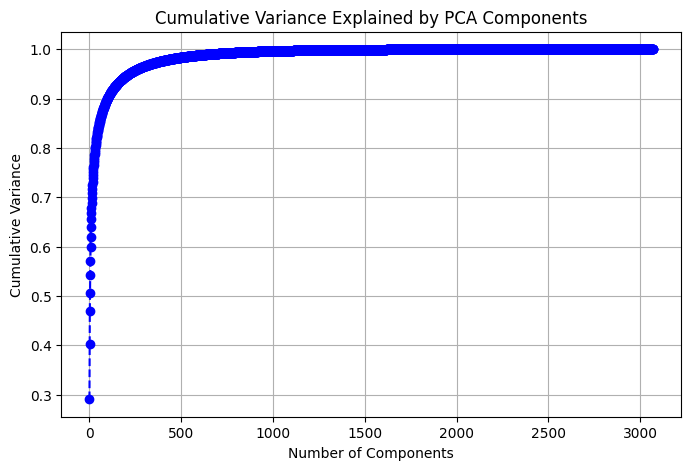

In [30]:
pca = PCA()
pca.fit(x_train_flat)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(cumsum, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Variance Explained by PCA Components")
plt.grid()
plt.show()

In [31]:
n_components = np.argmax(cumsum >= 0.95) + 1
print(f"Number of components selected to retain 95% variance: {n_components}")

Number of components selected to retain 95% variance: 217


In [32]:
pca = PCA(n_components=n_components)
train_PCA = pca.fit_transform(x_train_flat)
test_PCA = pca.transform(x_test_flat)

In [33]:
mlp_model = Sequential([
    Input(shape=(n_components,)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

mlp_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)



#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, min_lr = 1e-5, patience = 4, verbose = 0)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/mlp_best.h5', save_best_only=True, monitor='accuracy', mode='max')
csv_logger = tf.keras.callbacks.CSVLogger('mlp.log')

mlp_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history = mlp_model.fit(train_PCA, y_train_one_hot, epochs = 100, batch_size = 32, callbacks = [model_checkpoint, csv_logger])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 217)               0         
                                                                 
 dense_24 (Dense)            (None, 512)               111616    
                                                                 
 batch_normalization_18 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_19 (Bat  (None, 256)              1024      
 chNormalization)                                     

313/313 [==============================] - 1s 3ms/step
Final Test Loss: 1.2364
Final Test Accuracy: 0.5830


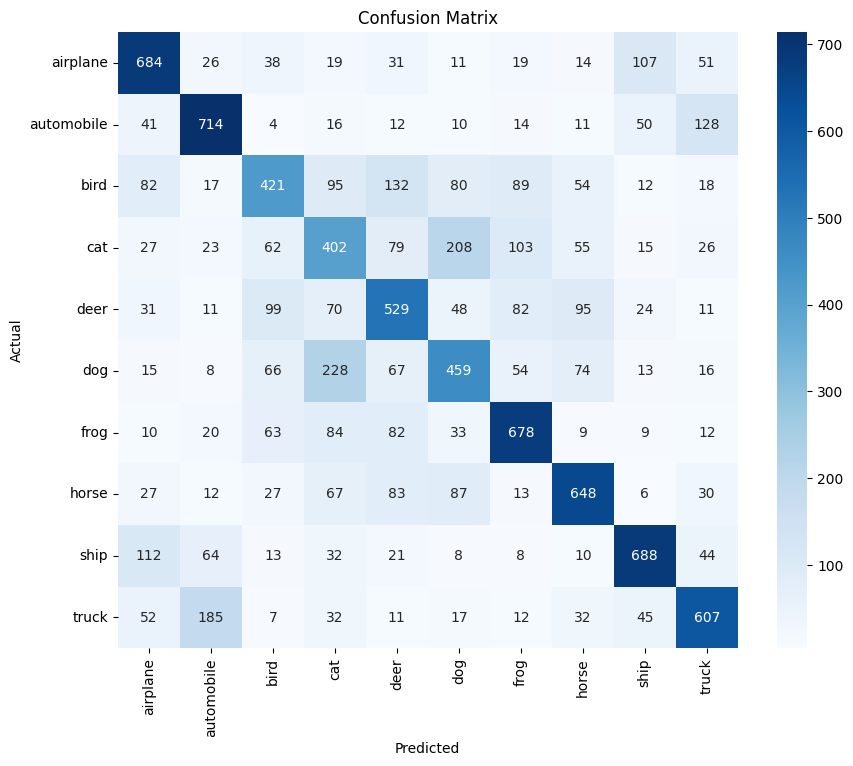

In [37]:
y_pred = mlp_model.predict(test_PCA)
y_pred_labels = np.argmax(y_pred, axis=1)


# Evaluate the classifier on the test set
test_loss, test_accuracy = mlp_model.evaluate(test_PCA, y_test_one_hot, verbose=0)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels.values(), yticklabels=cifar10_labels.values())
plt.xlabel("Predictie")
plt.ylabel("Valoare reala")
plt.title("Matrice de confuzie")
plt.show()